## Chapter 5

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Example 5.9 (Brownian dynamics sampling)

In [38]:
R = 1. # variance of observed value
B = 1./2 # variance of prior
dobs = 2. # mean of observed value
x0 = -2. # mean of prior

dx = 0.00001
xgrid = np.arange(-4.,1.+dx,dx)

prior = 1./np.sqrt(2. * np.pi * B) * np.exp(-(xgrid-x0)**2 / (2. * B))
prior = prior/np.sum(prior)/dx

# non-linear forward map
def obsgf(xgrid):
    return 7./12 * xgrid**3 - 7./2 * xgrid**2 + 8 * xgrid

obsg = obsgf(xgrid)
lik = 1./np.sqrt(2. * np.pi * R) * np.exp(-(obsg - dobs)**2 / (2. * R))
post = lik * prior / np.sum(lik * prior) / dx

# posterior mean
mean_post = np.sum(post * xgrid * dx)
var_post = np.sum(post * (xgrid - mean_post)**2 * dx)
print("posterior mean = %.4f" %mean_post)
print("posterior var = %.4f" %var_post)

# posterior median
h = 0
i = 0
while h <= .5:
    h += post[i] * dx
    i += 1

print("posterior median = %.4f" %xgrid[i])

# maximum posterior estimator (global maximum!) over the grid
i = 0 
while post[i] <= post[i+1]:
    i += 1

print("posterior MAP (over grid) = %.4f" %xgrid[i])

# maximum posterior estimator (Newton method)
mapost = mean_post
eps = 1.

while eps > 1e-8:
    obsg = obsgf(mapost)
    
    # f is the negative exponent of eqn (5.7).
    # finding argument for the smallest f yields the maxima of the pdf (our goal!)
    f = (mapost-x0)**2 / (2. * B) + (obsg - dobs)**2 / (2. ** R)
    Df = 1./B*(mapost-x0) + 1./R * (obsg - dobs) * (7./4 * mapost**2 - 7. * mapost + 8)
    
    alpha = 1.
    t = 0.
    
    # line search: find a proper step-size to ensure decreasing f's.
    while t < .5:
        mapn = mapost - alpha * Df
        alpha /= 2.
        
        obsg = obsgf(mapn)
        fn = (mapn-x0)**2 / (2. * B) + (obsg - dobs)**2 / (2. ** R)
        
        if fn <= f:
            t = 1.
    
    eps = np.abs(mapn-mapost)
    mapost= mapn
    
print("posterior MAP (Newton method) = %.4f" %xgrid[i])

posterior mean = 0.2095
posterior var = 0.0211
posterior median = 0.2006
posterior MAP (over grid) = 0.1837
posterior MAP (Newton method) = 0.1837


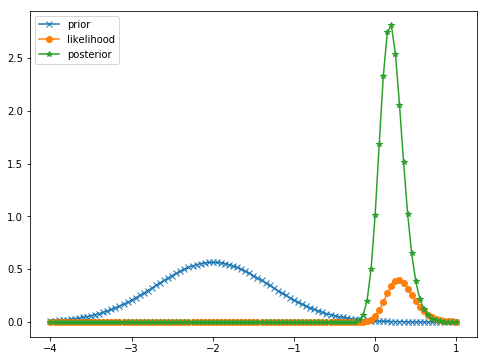

In [32]:
dx = 0.05
xgrid = np.arange(-4.,1.+dx,dx)
prior = 1./np.sqrt(2. * np.pi * B) * np.exp(-(xgrid-x0)**2 / (2. * B))
prior = prior/np.sum(prior)/dx

# non-linear forward map
obsg = 7./12 * xgrid**3 - 7./2 * xgrid**2 + 8 * xgrid
lik = 1./np.sqrt(2. * np.pi * R) * np.exp(-(obsg - dobs)**2 / (2. * R))
# lik = lik / np.sum(lik) / dx
post = lik * prior / np.sum(lik * prior) / dx

fig0 = plt.figure(figsize=(8,6))
plt.plot(xgrid,prior, 'x-', label="prior")
plt.plot(xgrid,lik, '-o', label="likelihood")
plt.plot(xgrid,post, '-*', label="posterior")
plt.legend()
plt.show()

### Example 5.14

In [137]:
R = 1.
B = .5
yobs = 2.
x0 = -2.

dx = 0.00001
xgrid = np.arange(-4.,2.+dx,dx)
prior = 1./np.sqrt(2. * np.pi * B) * np.exp(-(xgrid - x0)**2 / (2. * B))
prior = prior/sum(prior)/dx
obsg = obsgf(xgrid)
lik = 1./np.sqrt(2. * np.pi * R) * np.exp(-(obsg - dobs)**2 / (2. * R))
post = lik * prior / np.sum(lik * prior) / dx

mean_post = np.sum(post * xgrid * dx)
var_post = np.sum(post * (xgrid - mean_post)**2 * dx)

STEPS = 130000
dt = 0.001
x = x0

# gradient of the potential
def tstep(x,x0,dt):
    return (dt * (1./B * (x - x0) + 1./R * (7./12*x**3 - 7./2*x**2 + 8.*x - 2.) * (7./4*x**2 - 7.*x + 8.)) \
    + np.sqrt(2. * dt) * np.random.randn())

# Euler-Maruyama equilibration
for j in range(1000):
    x = x - tstep(x,x0,dt)
    
xout = np.zeros((STEPS))
xmean = np.empty_like(xout)
xvar = np.empty_like(xout)
xout[0] = x
xmean[0] = x

for j in range(STEPS-1):
    x = x - tstep(x,x0,dt)
    xout[j+1] = x
    xmean[j+1] = np.mean(xout[:j+1])
    xvar[j+1] = np.var(xout[:j+1])
    
xprior = x0 + np.sqrt(B) * np.random.randn(STEPS)

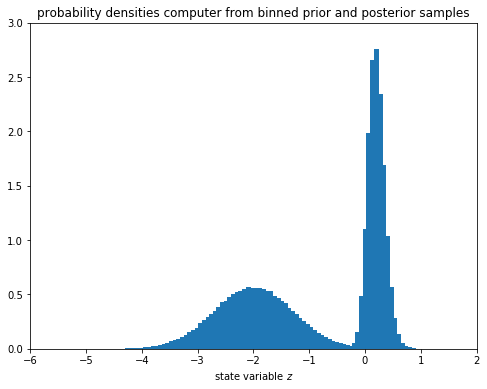

In [138]:
fig1 = plt.figure(figsize=(8,6))
nn, xh = np.histogram(np.vstack((xout,xprior)),100)
xh = (xh[1:] + xh[:-1])/2
nn = nn.astype('float')
nn = 2.*nn/np.sum(nn)/(xh[1]-xh[0])
plt.bar(xh,nn,width=0.1)
plt.ylim([0.,3.])
plt.xlim([-6.,2.])
plt.xlabel(r"state variable $z$")
plt.title("probability densities computer from binned prior and posterior samples")
plt.show()

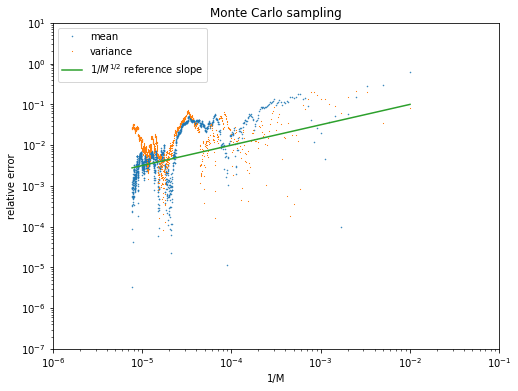

In [139]:
fig2 = plt.figure(figsize=(8,6))
M = np.arange(100,STEPS,100)
plt.loglog(1./M, np.abs(xmean[M]-mean_post) / np.abs(mean_post), 'o', ms=0.5, label="mean")
plt.loglog(1./M, np.abs(xvar[M]-var_post) / var_post, 'x', ms=0.5, label="variance")
plt.loglog(1./M, np.sqrt(1./M), '-', label=r"$1/M^{1/2}$ reference slope")
plt.xlim([1e-6,1e-1])
plt.ylim([1e-7,1e1])
plt.title("Monte Carlo sampling")
plt.xlabel("1/M")
plt.ylabel("relative error")
plt.legend()
plt.show()

### Example 5.16 (Importance sampling)

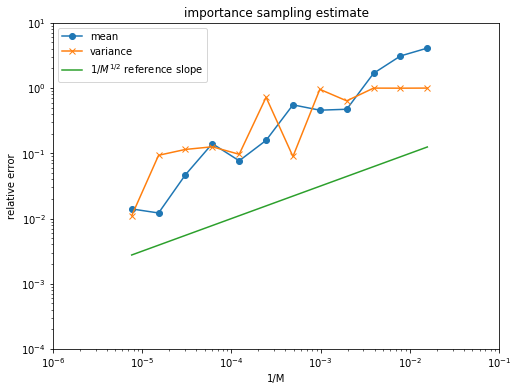

In [151]:
R = 1.
B = 1./2
yobs = 2.
x0 = -2.

mean_post = 0.2095
var_post = 0.0211

M = np.arange(1,13)
M = 2.**5 * 2.**M

xmean = np.zeros((12))
xvar = np.zeros((12))
err1 = np.zeros((12))
err2 = np.zeros((12))

for i in range(12):
    # recall that the prior is a normal distribution with mean = x0, and variance = 0.5.
    xf = x0 + np.sqrt(B) * np.random.randn(int(M[i]))
    obsg = obsgf(xf)
    
    # generate weights (5.25)
    ww = np.exp(-(obsg - yobs)**2 / (2. * R))
    ww /= np.sum(ww)
    
    xmean[i] = np.sum(ww * xf)
    xvar[i] = np.sum(ww * (xf - xmean[i])**2)
    err1[i] = np.abs(xmean[i] - mean_post) / np.abs(mean_post)
    err2[i] = np.abs(xvar[i] - var_post) / var_post
    
fig3 = plt.figure(figsize=(8,6))
plt.loglog(1./M,err1, '-o', label = "mean")
plt.loglog(1./M,err2, '-x', label = "variance")
plt.loglog(1./M,np.sqrt(1./M), label = "$1/M^{1/2}$ reference slope")
plt.xlabel("1/M")
plt.ylabel("relative error")
plt.title("importance sampling estimate")
plt.xlim([1e-6, 1e-1])
plt.ylim([1e-4, 1e1])
plt.legend()
plt.show()

### Example 5.17 (Optimal coupling for Bayesian inference)

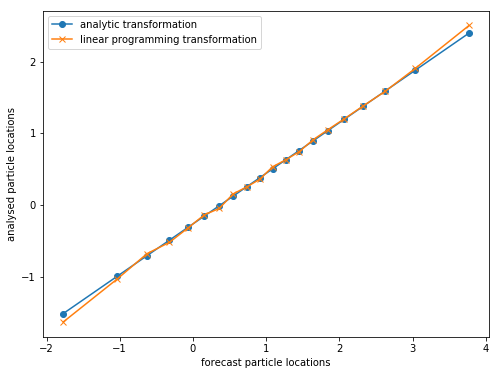

In [278]:
from scipy.special import erfinv
from scipy.sparse import lil_matrix, find

# Ensemble size
M = 20

# prior mean and var
xmf = 1.
Pf = 2.

# prior ensemble
ur = np.arange(.5,M) / M
xr = np.sqrt(2.) * erfinv(2.*ur - 1)
xf = xmf + np.sqrt(Pf) * xr
xf = np.sort(xf)

yobs = -0.1
R = 2.0

# recall (5.25)
w = np.exp(-(yobs - xf)**2 / (2. * R))
w /= np.sum(w)

T = lil_matrix((M,M))
j = 0
i = 0
dx = np.ones(M)/M
dy = w

while i*j <= (M-1)*(M-1):
    if dy[i] < dx[j]:
        T[i,j] = dy[i]
        dx[j] = dx[j] - dy[i]
        dy[i] = 0
        i += 1
    else:
        T[i,j] = dx[j]
        dy[i] = dy[i] - dx[j]
        dx[j] = 0
        j += 1

# posterior samples
xa = xf.T * T * M

xma = np.mean(xa)
Pa = np.var(xa)
Pa3 = np.mean((xa-xma)**3)
Pa4 = np.mean((xa-xma)**4)

PA = 1.

# analytic transformation
xA = xma + np.sqrt(PA) * np.sqrt(2.) * erfinv(2. * ur - 1.)

fig4 = plt.figure(figsize=(8,6))
plt.plot(xf,xA, '-o', label="analytic transformation")
plt.plot(xf,xa, '-x', label="linear programming transformation")
plt.legend()
plt.xlabel("forecast particle locations")
plt.ylabel("analysed particle locations")
plt.show()

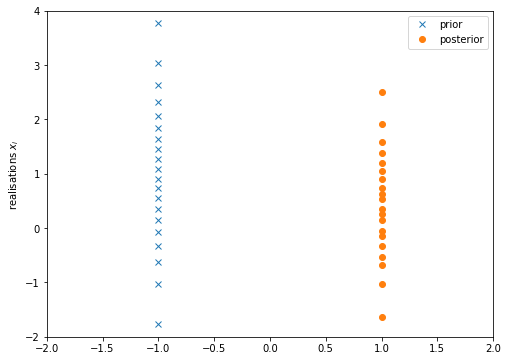

In [220]:
fig5 = plt.figure(figsize=(8,6))
plt.plot(-np.ones(xf.shape),xf, 'x', label="prior")
plt.plot(np.ones(xa.shape),xa, 'o', label="posterior")
plt.legend()
plt.xlim([-2,2])
plt.ylim([-2,4])
plt.ylabel("realisations $x_i$")
plt.show()

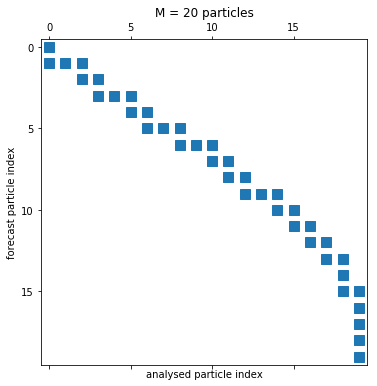

In [221]:
i,j,s = find(T*M)

fig6 = plt.figure(figsize=(6,6))
plt.spy(T)
plt.title('M = 20 particles')
plt.xlabel(r'analysed particle index')
plt.ylabel(r'forecast particle index')
plt.show()

In [304]:
# Ensemble size
Ms = np.array([10,40,100,500])

# prior mean and var
xmf = 1.
Pf = 2.

xma = np.zeros((Ms.shape))
Pa = np.zeros((Ms.shape))
Pa3 = np.zeros((Ms.shape))
Pa4 = np.zeros((Ms.shape))

# prior ensemble
k = 0
for M in Ms:
    ur = np.arange(0.5,M) / M
    xr = np.sqrt(2.) * erfinv(2.*ur - 1.)
    xf = xmf + np.sqrt(Pf) * xr
    xf = np.sort(xf)

    yobs = -0.1
    R = 2.

    w = np.exp(-(xf - yobs)**2 / (2. * R))
    w /= np.sum(w)
    
    T = lil_matrix((M,M))
    j = 0
    i = 0
    dx = np.ones(M)/M
    dy = np.copy(w)

    while i*j <= (M-1)*(M-1):
        if dy[i] < dx[j]:
            T[i,j] = dy[i]
            dx[j] = dx[j] - dy[i]
            dy[i] = 0
            i += 1
        else:
            T[i,j] = dx[j]
            dy[i] = dy[i] - dx[j]
            dx[j] = 0
            j += 1

    # posterior samples
    xa = xf * T * M

    xma[k] = np.mean(xa)
    Pa[k] = np.var(xa)
    Pa3[k] = np.mean((xa-xma[k])**3)
    Pa4[k] = np.mean((xa-xma[k])**4)
    
    k += 1
    
from tabulate import tabulate

moments = np.vstack((Ms.T,xma.T,Pa.T,Pa3.T,Pa4.T))
print tabulate(moments.T, headers=['M','mean','var','skewness','kurtosis'])

  M      mean       var      skewness    kurtosis
---  --------  --------  ------------  ----------
 10  0.434499  0.971324   0.0265211       2.24871
 40  0.446613  0.998837  -0.00490715      2.787
100  0.449052  1.00024   -0.00574605      2.92479
500  0.449918  0.999934  -0.000802403     2.98235


In [295]:
R = 2. # variance of observed value
B = 2. # variance of prior
dobs = 0.1 # mean of observed value
x0 = 1. # mean of prior

dx = 0.00001
xgrid = np.arange(-10.,10.+dx,dx)

prior = 1./np.sqrt(2. * np.pi * B) * np.exp(-(xgrid-x0)**2 / (2. * B))
prior = prior/np.sum(prior)/dx

lik = 1./np.sqrt(2. * np.pi * R) * np.exp(-(xgrid - dobs)**2 / (2. * R))
post = lik * prior / np.sum(lik * prior) / dx

# posterior mean
mean_post = np.sum(post * xgrid * dx)
var_post = np.sum(post * (xgrid - mean_post)**2 * dx)
print("posterior mean = %.4f" %mean_post)
print("posterior var = %.4f" %var_post)

posterior mean = 0.5500
posterior var = 1.0000


### Example 5.20

In [332]:
R = 1.
B = 1./2
yobs = 2.
x0 = -2.

dx = 0.00001
xgrid = np.arange(-4.,2.+dx,dx)
prior = 1./np.sqrt(2. * np.pi * B) * np.exp(-(xgrid-x0)**2 / (2. * B))
prior = prior/np.sum(prior)/dx

obsg = obsgf(xgrid)
lik = 1./np.sqrt(2. * np.pi * R) * np.exp(-(obsg - yobs)**2 / (2. * R))
lik = lik / np.sum(lik) / dx
post = lik * prior / np.sum(lik * prior) / dx

# "exact" posterior mean and variance
mean_post = np.sum(post * xgrid * dx)
var_post = np.sum(post * (xgrid - mean_post)**2 * dx)

ms = np.arange(1,13)
ms = np.array([(2**5 * 2**m) for m in ms])

xmeanf = np.zeros((12))
xvarf = np.zeros((12))
err1f = np.zeros((12))
err2f = np.zeros((12))

xmeana = np.zeros((12))
xvara = np.zeros((12))
err1a = np.zeros((12))
err2a = np.zeros((12))

for ii in range(12):
    M = ms[ii]
    xf0 = x0 + np.sqrt(B) * np.random.randn(M)
    xf0 = np.sort(xf0)
    
    obsg = obsgf(xf0)
    
    w = np.exp(-(obsg - yobs)**2 / (2. * R))
    w /= np.sum(w)
    
    xmeanf[ii] = np.sum(w * xf0)
    xvarf[ii] = np.sum(w * (xf0 - xmeanf[ii])**2)
    err1f[ii] = np.abs(xmeanf[ii] - mean_post) / np.abs(mean_post)
    err2f[ii] = np.abs(xvarf[ii] - var_post) / var_post
    
    xf = np.copy(xf0)
    
    T = lil_matrix((M,M))
    j = 0
    i = 0
    dx = np.ones(M)/M
    dy = np.copy(w)

    while i*j <= (M-1)*(M-1):
        if dy[i] < dx[j]:
            T[i,j] = dy[i]
            dx[j] = dx[j] - dy[i]
            dy[i] = 0
            i += 1
        else:
            T[i,j] = dx[j]
            dy[i] = dy[i] - dx[j]
            dx[j] = 0
            j += 1

    # posterior samples
    xa = xf * T * M
    
    xmeana[ii] = np.sum(xa) / M
    xvara[ii] = np.sum((xa - xmeana[ii])**2) / (M-1)
    err1a[ii] = np.abs(xmeana[ii] - mean_post) / np.abs(mean_post)
    err2a[ii] = np.abs(xvara[ii] - var_post) / var_post

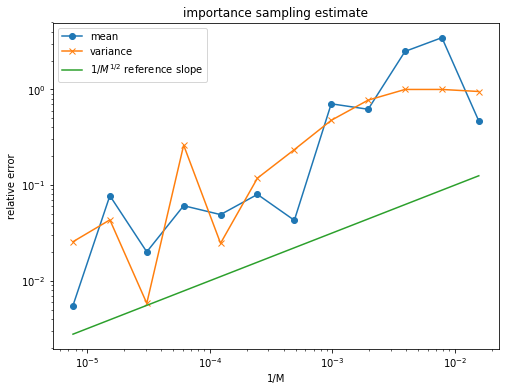

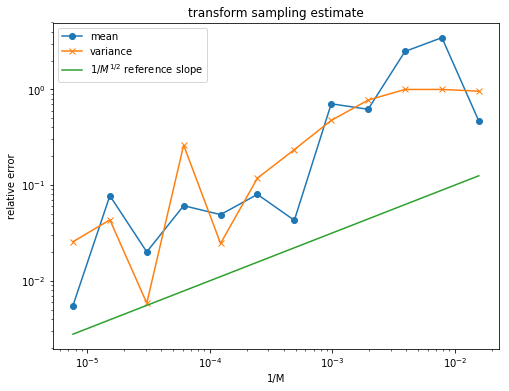

In [333]:
fig7a = plt.figure(figsize=(8,6))
plt.loglog(1./ms, err1f, '-o', label="mean")
plt.loglog(1./ms, err2f, '-x', label="variance")
plt.loglog(1./ms, np.sqrt(1./ms), label = "$1/M^{1/2}$ reference slope")
plt.title("importance sampling estimate")
plt.xlabel("1/M")
plt.ylabel("relative error")
plt.legend()
plt.show()

fig7b = plt.figure(figsize=(8,6))
plt.loglog(1./ms, err1a, '-o', label="mean")
plt.loglog(1./ms, err2a, '-x', label="variance")
plt.loglog(1./ms, np.sqrt(1./ms), label = "$1/M^{1/2}$ reference slope")
plt.title("transform sampling estimate")
plt.xlabel("1/M")
plt.ylabel("relative error")
plt.legend()
plt.show()

### Example 5.25

In [335]:
AA = np.arange(25)
print(AA)
AAp = np.roll(AA,1)
print(AAp)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[24  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23]


eigenvalues = [-5.11057863e-10+0.j -2.99781542e+00+0.j]


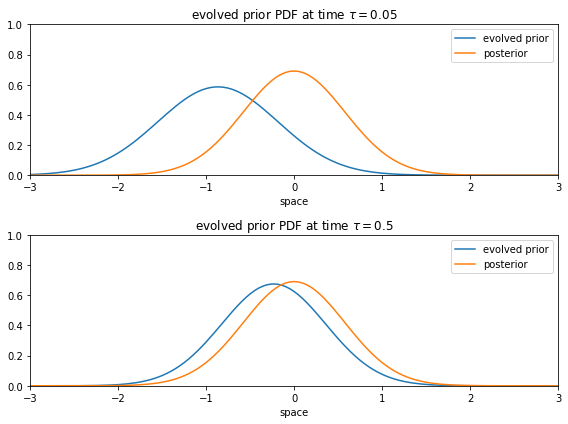

In [376]:
from scipy.sparse import spdiags
from scipy.sparse.linalg import eigs

R = 1.
B = 1./2
yosb = 1.
x0 = -1.

dx = 0.05
xgrid = np.arange(-4.,4.+dx,dx)

prior = 1./np.sqrt(2. * np.pi * B) * np.exp(-(xgrid-x0)**2 / (2. * B))
prior = prior / np.sum(prior) / dx

obsg = xgrid

lik = 1./np.sqrt(2. * np.pi * R) * np.exp(-(obsg-yobs)**2 / (2. * R))
lik = lik / np.sum(lik) / dx

post = lik * prior / np.sum(lik * prior) / dx

xgridh = xgrid + dx/2

priorh = 1./np.sqrt(2. * np.pi * B) * np.exp(-(xgrid-x0)**2 / (2. * B))
priorh = priorh / np.sum(priorh) / dx

obsgh = xgridh

likh = 1./np.sqrt(2. * np.pi * R) * np.exp(-(obsgh - yobs)**2 / (2. * R))
likh = likh / np.sum(likh) / dx
posth = likh * priorh / np.sum(likh * priorh) / dx

dt = 6.25 * 1e-4
pd = 1. - dt / dx**2 * (posth + np.roll(posth,1)) / post
pp = dt / dx**2 * posth / np.roll(post,-1)
pm = dt / dx**2 * np.roll(posth,1) / np.roll(post,1)

M = xgrid.shape[0] - 1
P = spdiags(np.vstack((pp[1:],pd[1:],pm[1:])), [-1,0,1], M, M)
P = P.T

l= np.log(eigs(P,2)[0]) / dt
print("eigenvalues = %s" %l)

p0 = prior[1:]
p0 = p0 / np.sum(p0) / dx
time = 0.

while time <= 0.05:
    p0 = P * p0
    eps = np.sqrt(np.sum(p0 - post[1:])**2) * dx
    time += dt
    
fig8 = plt.figure(figsize=(8,6))
ax1 = fig8.add_subplot(2, 1, 1)
ax1.plot(xgrid[1:],p0, label="evolved prior")
ax1.plot(xgrid[1:],post[1:], label="posterior")
ax1.set_xlabel("space")
ax1.set_title(r"evolved prior PDF at time $\tau = 0.05$")
ax1.set_xlim([-3.,3.])
ax1.set_ylim([0.,1.])
ax1.legend()

while time <= 0.5:
    p0 = P * p0
    eps = np.sqrt(np.sum(p0 - post[1:])**2) * dx
    time += dt

ax2 = fig8.add_subplot(2, 1, 2)
ax2.plot(xgrid[1:],p0, label="evolved prior")
ax2.plot(xgrid[1:],post[1:], label="posterior")
ax2.set_xlabel("space")
ax2.set_title(r"evolved prior PDF at time $\tau = 0.5$")
ax2.set_xlim([-3.,3.])
ax2.set_ylim([0.,1.])
ax2.legend()

plt.tight_layout()
plt.show()